In [20]:

two_p_results = {"1024-256": [
        "/mnt/network_drive/lrq/logs/logs_2025-10-13-16-22-50/run_0",
        "/mnt/network_drive/lrq/logs/logs_2025-10-13-16-49-18/run_0",
        "/mnt/network_drive/lrq/logs/logs_2025-10-13-16-49-18/run_1",
        "/mnt/network_drive/lrq/logs/logs_2025-10-14-22-11-03/run_0",
        "/mnt/network_drive/lrq/logs/logs_2025-10-14-22-19-34/run_0",
    ],}

In [21]:
from analyze import analyze_data
from utils import RequestData
import json
from datetime import datetime
from zoneinfo import ZoneInfo
import numpy as np
import os
import re
exp_log_dir_map = {
    "1024-128": [
        "/mnt/network_drive/lrq/logs/logs_2025-10-23-11-23-03/run_0",
        "/mnt/network_drive/lrq/logs/logs_2025-10-23-11-23-03/run_1",
        "/mnt/network_drive/lrq/logs/logs_2025-10-23-11-23-03/run_2",
        "/mnt/network_drive/lrq/logs/logs_2025-10-23-11-23-03/run_3",
        "/mnt/network_drive/lrq/logs/logs_2025-10-23-11-23-03/run_4",
        "/mnt/network_drive/lrq/logs/logs_2025-10-23-15-39-32/run_0",
        "/mnt/network_drive/lrq/logs/logs_2025-10-23-15-39-32/run_1",
    ],
    "8192-128": [
        "/mnt/network_drive/lrq/logs/logs_2025-11-15-17-07-12/run_0",
    ],
    "8192-512": [
        "/mnt/network_drive/lrq/logs/logs_2025-11-15-16-19-44/run_0",
        "/mnt/network_drive/lrq/logs/logs_2025-11-15-16-19-44/run_1",
        "/mnt/network_drive/lrq/logs/logs_2025-11-15-16-19-44/run_2",
        "/mnt/network_drive/lrq/logs/logs_2025-11-15-16-06-34/run_0",
    ]
}
result_map = {}
BASE_RPS = 10
metrics_list = []
for experiment_label, exp_log_dir in exp_log_dir_map.items():
    if type(exp_log_dir) == str:
        result_map[experiment_label] = {}
        with open(f"{exp_log_dir}/sweep.json", 'r') as f:
            sweep_data = json.load(f)

        sampling_rates = sweep_data['loadgen_configs/loadgen_config.json::sampling_rate']
        rps = [BASE_RPS * rate / 100 for rate in sampling_rates]
        result_map[experiment_label] = {
            "rps": rps,
        }
    
    
        run_log_dirs = [os.path.join(exp_log_dir, entry.name) for entry in os.scandir(exp_log_dir) if entry.is_dir() and entry.name.startswith('run_')]
        run_log_dirs = sorted(run_log_dirs, key=lambda x: int(x.split('_')[-1]))
        print(run_log_dirs)
    else:
        run_log_dirs = exp_log_dir
        result_map[experiment_label] = {}
        sampling_rates = []
        for run_log_dir in run_log_dirs: 
            with open(f"{run_log_dir}/config.json", 'r') as f:
                config = json.load(f)
            sampling_rate = config['LLMLoadgen_config']['sampling_rate']
            sampling_rates.append(sampling_rate)
        rps = [BASE_RPS * rate / 100 for rate in sampling_rates]
        result_map[experiment_label] = {
            "rps": rps,
        }

    result_map[experiment_label]['finished_rates'] = []
    for run_log_dir in run_log_dirs:
        report_file_path = os.path.join(run_log_dir, 'report.json')
        if not os.path.exists(report_file_path):
            print(f"Report file not found for {run_log_dir}, analyzing data...")
            report_file_path = analyze_data(run_log_dir, metrics_list)

        with open(report_file_path, 'r') as f:
            report = json.load(f)

        loadgen_data = report['loadgen_data']


        start_str = report.get('router_start_time', 'N/A')
        end_str = report.get('router_end_time', 'N/A')
        tz_sg = ZoneInfo("Asia/Singapore")
        router_start_time = datetime.fromisoformat(start_str).replace(tzinfo=tz_sg).timestamp()
        router_end_time = datetime.fromisoformat(end_str).replace(tzinfo=tz_sg).timestamp()
        pattern = re.compile(r"^(\d{4}/\d{2}/\d{2} \d{2}:\d{2}:\d{2}) Finished preparing http requests")
        with open(f"{run_log_dir}/loadgen.err") as f:
            for line in f:
                m = pattern.match(line)
                if m:
                    dt = datetime.strptime(m.group(1), "%Y/%m/%d %H:%M:%S").replace(tzinfo=tz_sg)
                    break

        first_request_sendtime = dt.timestamp() + 5
        print(f"Router start time: {router_start_time}, end time: {router_end_time}")
        decode_times = []
        finished_tokens = []
        prefill_tokens = []
        decode_tokens = []
        tpots = []
        requests = []
        for request_data in loadgen_data:
            if 'error' in request_data:
                continue

            request = RequestData.init_from_dict(request_data)
            requests.append(request)

            arrival_time = request.arrival_time
            decode_finished_time = arrival_time + request.ttft + request.waiting_latency + request.decode_latency


            decode_times.append(decode_finished_time)
            finished_tokens.append(request.decode_tokens+request.prompt_tokens)
            prefill_tokens.append(request.prompt_tokens)
            decode_tokens.append(request.decode_tokens)
            tpot = request.decode_latency / request.decode_tokens if request.decode_tokens > 0 else 0
            tpots.append(tpot)

        assert len(decode_times) == len(finished_tokens)


        first_request_arrival_time = float('inf')
        last_request_finished_time = 0
        token_count = 0
        for request in requests:
            if request.arrival_time < first_request_arrival_time:
                first_request_arrival_time = request.arrival_time
            request_finished_time = request.arrival_time + request.ttft + request.waiting_latency + request.decode_latency
            if request_finished_time > last_request_finished_time:
                last_request_finished_time = request_finished_time
            token_count += request.prompt_tokens + request.decode_tokens
        avg_finished_rate = token_count / (last_request_finished_time - first_request_arrival_time)
        result_map[experiment_label]['finished_rates'].append(avg_finished_rate)
        print(f"Average finished rate: {avg_finished_rate} tokens/s")


    

Router start time: 1761189820.996637, end time: 1761190139.540869
Average finished rate: 16666.182979681893 tokens/s
Router start time: 1761189879.804512, end time: 1761190215.457303
Average finished rate: 19439.109489454964 tokens/s
Router start time: 1761189939.467734, end time: 1761190260.663042
Average finished rate: 22112.29340047996 tokens/s
Router start time: 1761190194.06408, end time: 1761190508.577305
Average finished rate: 24337.662449254465 tokens/s
Router start time: 1761190261.207734, end time: 1761190577.555662
Average finished rate: 24917.611391963495 tokens/s
Router start time: 1761205210.285334, end time: 1761205950.45491
Average finished rate: 19660.777922008023 tokens/s
Router start time: 1761205374.659002, end time: 1761205936.436521
Average finished rate: 20458.544474001174 tokens/s
Report file not found for /mnt/network_drive/lrq/logs/logs_2025-11-15-17-07-12/run_0, analyzing data...
Copying Prometheus snapshot from /data/metrics to /app/prometheus_restore...
QUE

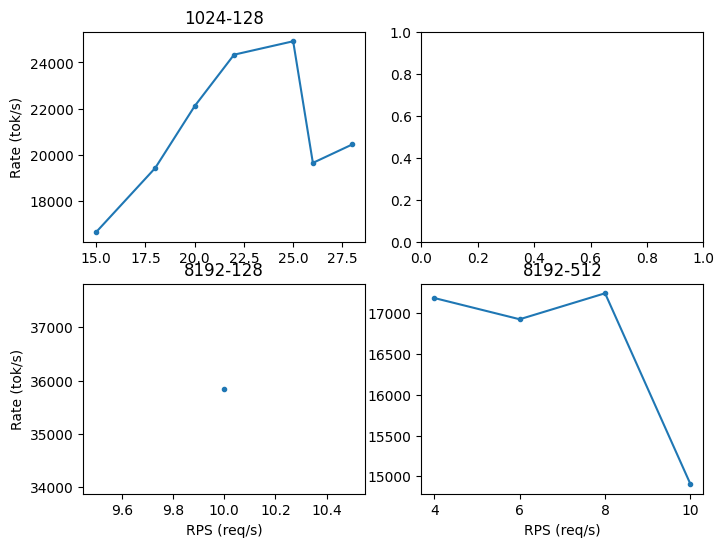

In [22]:
import matplotlib.pyplot as plt
inputs_list = []
outputs_list = []
for experiment_label, result in result_map.items():
    splits = experiment_label.split('-')
    if len(splits) == 2:
        input = int(splits[0])
        output = int(splits[1])
        if input not in inputs_list:
            inputs_list.append(input)
        if output not in outputs_list:
            outputs_list.append(output)

inputs = sorted(inputs_list)
outputs = sorted(outputs_list)

num_rows = len(inputs)
row_index_map = {}
for i, input in enumerate(inputs):
    row_index_map[input] = i

num_cols = len(outputs)
col_index_map = {}
for i, output in enumerate(outputs):
    col_index_map[output] = i

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 3*num_rows))
for experiment_label, result in result_map.items():
    splits = experiment_label.split('-')
    input = int(splits[0])
    output = int(splits[1])
    row_index = row_index_map[input]
    col_index = col_index_map[output]
    input, output = int(splits[0]), int(splits[1])
    row_index = row_index_map[int(experiment_label.split('-')[0])]
    axes[row_index][col_index].plot(result['rps'], result['finished_rates'], label="finished rates", marker='.')
    if row_index == len(inputs) - 1:
        axes[row_index][col_index].set_xlabel("RPS (req/s)")
    if col_index == 0:
        axes[row_index][col_index].set_ylabel("Rate (tok/s)")
    axes[row_index][col_index].set_title(experiment_label)


Input: 1024, Output: 128, Finished Rate Capacity: 24917.6 tok/s
Input: 8192, Output: 128, Finished Rate Capacity: 35846.8 tok/s
Input: 8192, Output: 512, Finished Rate Capacity: 17245.3 tok/s


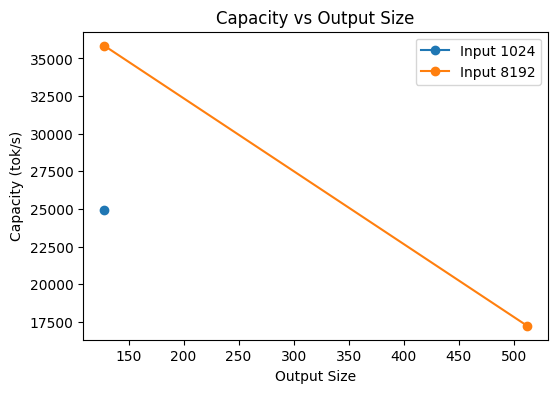

In [23]:

capacity_map = {}
for exp_label, result in result_map.items():
    splits = exp_label.split('-')
    input = int(splits[0])
    output = int(splits[1])
    capacity = max(result['finished_rates'])
    print(f"Input: {input}, Output: {output}, Finished Rate Capacity: {capacity:.1f} tok/s")
    if input not in capacity_map:
        capacity_map[input] = {}
        capacity_map[input]['outputs'] = []
        capacity_map[input]['capacities'] = []

    capacity_map[input]['outputs'].append(output)
    capacity_map[input]['capacities'].append(capacity)

plt.figure(figsize=(6, 4))
for input_size, data in capacity_map.items():
    outputs = data['outputs']
    capacities = data['capacities']
    plt.plot(outputs, capacities, marker='o', label=f"Input {input_size}")
    plt.xlabel("Output Size")
    plt.ylabel("Capacity (tok/s)")
    plt.title(f"Capacity vs Output Size")
    plt.legend()
# plt.ylim([0, 20000])
plt.show()

Input: 1024, Output: 16, Finished Rate Capacity: 199340.8 tok/s
Input: 1024, Output: 128, Finished Rate Capacity: 24917.6 tok/s
Input: 8192, Output: 16, Finished Rate Capacity: 240445.0 tok/s
Input: 8192, Output: 128, Finished Rate Capacity: 35846.8 tok/s
Input: 8192, Output: 512, Finished Rate Capacity: 17245.3 tok/s


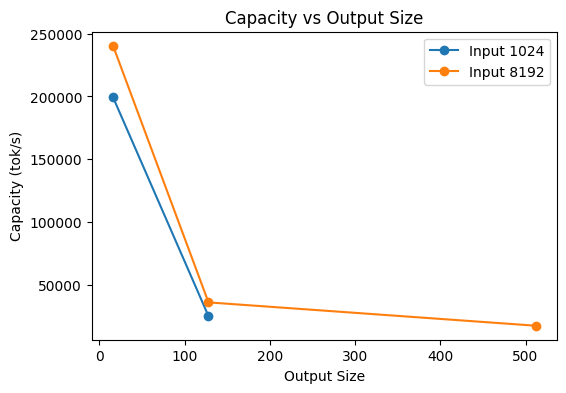

In [24]:
import matplotlib.pyplot as plt
inputs = [256, 1024, 8192]
# outputs = [128, 256, 384, 512]
outputs = [16, 128, 256, 384, 512]
capacity_map_copy = capacity_map.copy()

capacity_map_copy[1024]['outputs'] = [16] + capacity_map[1024]['outputs']
capacity_map_copy[1024]['capacities'] = [24917.6*8] + capacity_map[1024]['capacities']
capacity_map_copy[8192]['outputs'] = [16] + capacity_map[8192]['outputs']
capacity_map_copy[8192]['capacities'] = [24044.5*10] + capacity_map[8192]['capacities']
# capacity_map_copy[256]['outputs'] = [128] + capacity_map[256]['outputs']
# capacity_map_copy[256]['capacities'] = [17500] + capacity_map[256]['capacities']
# capacity_map_copy[256]['outputs'] = [16] + capacity_map[256]['outputs']
# capacity_map_copy[256]['capacities'] = [17500*8] + capacity_map[256]['capacities']


plt.figure(figsize=(6, 4))
for input_size, data in capacity_map_copy.items():
    outputs = data['outputs']
    capacities = data['capacities']
    for i, output in enumerate(outputs):
        print(f"Input: {input_size}, Output: {output}, Finished Rate Capacity: {capacities[i]:.1f} tok/s")
    plt.plot(outputs, capacities, marker='o', label=f"Input {input_size}")
    plt.xlabel("Output Size")
    plt.ylabel("Capacity (tok/s)")
    plt.title(f"Capacity vs Output Size")
    plt.legend()
# plt.ylim([0, 20000])
plt.show()